## Synchronize data

In [1]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np 
from scipy import signal

In [2]:
# load binary data
from open_ephys.analysis import Session

directory = r'E:\open-ephys-testdata\M4_D26-binary'

session = Session(directory)

In [3]:
recording = session.recordings[0].continuous[0]
Fs = 30000

In [4]:
data = recording.get_samples(0,-1)

In [5]:
bonsai_fs = 30

sync_pulse = data[:,19]
sync_pulse_ds = signal.decimate(sync_pulse, Fs//bonsai_fs, ftype='fir')
sync_pulse_ds = sync_pulse_ds > np.ptp(sync_pulse)/2

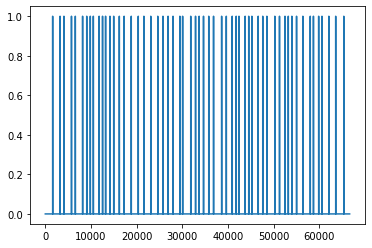

In [6]:
plt.plot(sync_pulse_ds)

In [23]:
# bonsai data
fn = r'E:\open-ephys-testdata\M4_D26-binary\M1-0208-of2021-09-15T12_07_05.csv'
df_bonsai = pd.read_csv(fn,delim_whitespace=True, names=['timestamp','left_x','left_y','right_x', 'right_y','sync'])

In [41]:
# calculate the sampling frequency of bonsai
from datetime import datetime
ts = df_bonsai.iloc[0].timestamp
t = datetime.strptime(ts[:-7], '%Y-%m-%dT%H:%M:%S.%f')


1631704026.688537

In [50]:
def convert_time(ts):
    return datetime.strptime(ts[:-7], '%Y-%m-%dT%H:%M:%S.%f').timestamp()

df_bonsai['ts'] = df_bonsai.timestamp.apply(convert_time)

print(f'Sampling rate is {1/np.nanmean(df_bonsai.ts.diff()):.2f}')

Sampling rate is 29.92


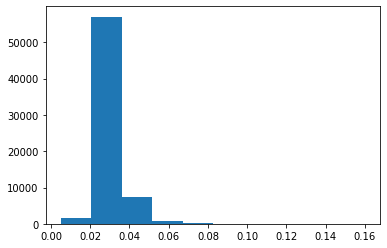

In [64]:
d = df_bonsai.ts.diff()
d = d[~np.isnan(d)]
plt.hist(d,10);

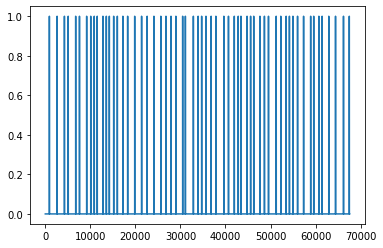

In [9]:
bonsai_sync = df_bonsai.sync.values
bonsai_sync = bonsai_sync>np.ptp(bonsai_sync)/2
plt.plot(bonsai_sync)

In [51]:
co = np.correlate(bonsai_sync.astype(int), sync_pulse_ds.astype(int),'full')


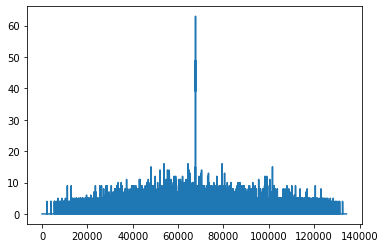

In [52]:
plt.plot(co)

In [53]:
maxidx = co.argmax()- len(sync_pulse_ds)
maxidx

1025

(1550.0, 1625.0)

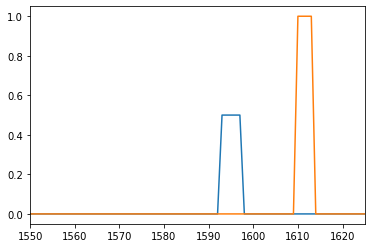

In [57]:
plt.plot(bonsai_sync[maxidx:]*0.5)
plt.plot(sync_pulse_ds)
plt.xlim([1550,1625])

## Export

In [150]:
df_bonsai = df_bonsai.fillna(method='ffill')

In [151]:
df_bonsai.iloc[maxidx:].to_csv('tracking_position.csv')